# Deterministic RNNs in SSM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindermanlab/ssm-jax-refactor/blob/main/notebooks/scratch/rnn.ipynb)

To fit the distributional notation of SSM-JAX, deterministic RNNs return _deterministic_ distributions over the output values.

This is accomplished by using the Tensorflow Probability `Deterministic` distribution.

In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
try:
    import ssm
except:
    import os
    from getpass import getpass
    user = getpass('GitHub user')
    password = getpass('GitHub token')
    os.environ['GITHUB_AUTH'] = user + ':' + password
    !pip install git+https://$GITHUB_AUTH@github.com/lindermanlab/ssm-jax-refactor.git -qqq
    del user, password
    import ssm

In [2]:
import jax.numpy as np
import jax.random as jr

from ssm.rnn import GRU

In [3]:
from matplotlib.gridspec import GridSpec 
import matplotlib.pyplot as plt

def plot_emissions(states, data):
    latent_dim = states.shape[-1]
    emissions_dim = data.shape[-1]
    num_timesteps = data.shape[0]
    
    plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

    lim = abs(states).max()
    plt.subplot(gs[0])
    for d in range(latent_dim):
        plt.plot(states[:, d] + lim * d, '-')
    plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
    plt.xticks([])
    plt.xlim(0, num_timesteps)
    plt.title("Sampled Latent States")

    lim = abs(data).max()
    plt.subplot(gs[1])
    for n in range(emissions_dim):
        plt.plot(data[:, n] - lim * n, '-k')
    plt.yticks(-np.arange(emissions_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(emissions_dim)])
    plt.xlabel("time")
    plt.xlim(0, num_timesteps)

    plt.title("Sampled Emissions")
    plt.tight_layout()

## Create a "true" RNN model

Let the emissions be the identity of the hidden states.

In [4]:
num_input_dims = 1
num_latent_dims = 2

rnn = GRU(num_input_dims, num_latent_dims, seed=jr.PRNGKey(0))

In [5]:
seed_1, seed_2, seed_3, seed_4 = jr.split(jr.PRNGKey(0), 4)
num_timesteps = 100
num_trials = 100

# generate train data
train_inputs = jr.normal(seed_1, shape=(num_trials, num_timesteps, num_input_dims))
train_states, train_dataset = rnn.sample(key=seed_2, covariates=train_inputs, num_steps=num_timesteps, num_samples=num_trials)

# generate test data
test_inputs = jr.normal(seed_3, shape=(num_trials, num_timesteps, num_input_dims))
test_states, test_dataset = rnn.sample(key=seed_4, covariates=test_inputs, num_steps=num_timesteps, num_samples=num_trials)

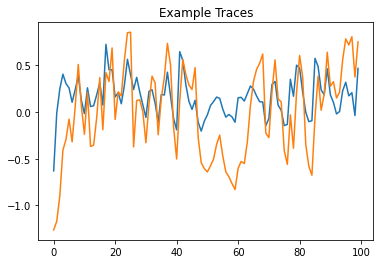

In [6]:
plt.plot(train_dataset[0])
plt.title("Example Traces")
plt.show()

# Create our Test RNN to fit to the data

In [7]:
test_rnn = GRU(num_input_dims, num_latent_dims, seed=jr.PRNGKey(42))

In [8]:
from jax import value_and_grad, jit
from jax.experimental import optimizers
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

@jit
def mse_loss(model, inputs, labels, seed):
    num_steps = inputs.shape[-2]
    _, pred_data = model.sample(key=seed, num_steps=num_steps, covariates=inputs)
    return np.mean(np.square(pred_data - labels))


@jit
def step(step, opt_state, seed):
    value, grads = value_and_grad(mse_loss)(opt.params_fn(opt_state), inputs, labels, seed)
    opt_state = opt.update_fn(step, grads, opt_state)
    return value, opt_state


seed = jr.PRNGKey(0)
num_epochs = 100
train_losses = []
val_losses = []

opt = optimizers.adam(step_size=1e-3)
opt_state = opt.init_fn(test_rnn)
for epoch in tqdm(range(1, num_epochs + 1)):
    for i, (inputs, labels) in enumerate(zip(train_inputs, train_dataset)):
        seed, this_seed = jr.split(seed, 2)
        loss, opt_state = step(epoch * i, opt_state, this_seed)
        train_losses.append(loss)
        
    # validation
    val_loss = 0.
    for (test_input, test_label) in zip(test_inputs, test_dataset):
        val_loss += mse_loss(opt.params_fn(opt_state), test_input, test_label, this_seed)
    val_loss /= test_dataset.shape[0]
    val_losses.append((epoch * i, val_loss))
val_losses = np.array(val_losses)


100%|██████████| 100/100 [00:03<00:00, 30.41it/s]


Text(0, 0.5, 'mse loss')

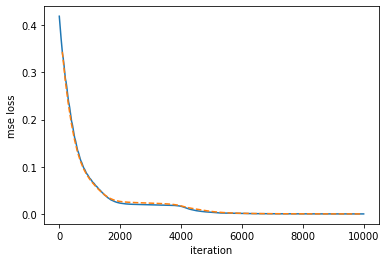

In [9]:
plt.plot(train_losses, label="train")
plt.plot(val_losses[:, 0], val_losses[:, 1], '--', label="val")
plt.xlabel("iteration")
plt.ylabel("mse loss")

In [10]:
fit_rnn = opt.params_fn(opt_state)

fit_test_states, fit_test_data = fit_rnn.sample(key=jr.PRNGKey(0), covariates=test_inputs, num_steps=num_timesteps, num_samples=num_trials)
fit_states, fit_data = fit_rnn.sample(key=jr.PRNGKey(0), covariates=train_inputs, num_steps=num_timesteps, num_samples=num_trials)

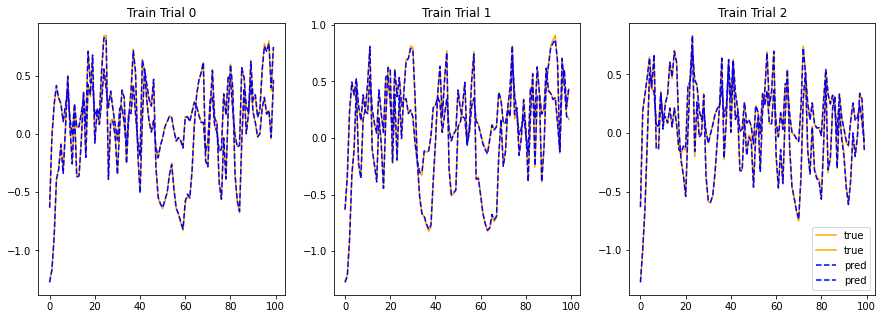

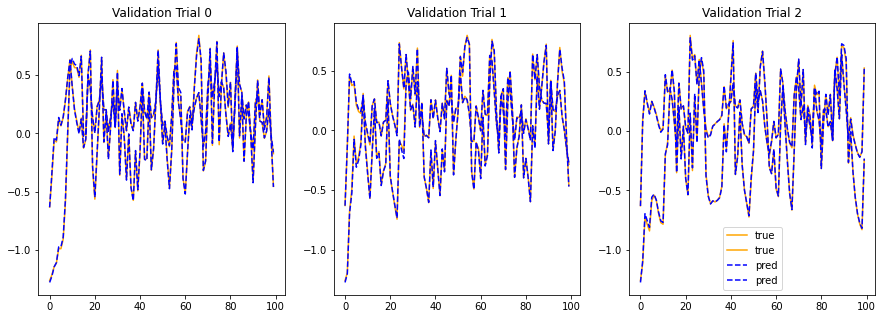

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx in range(3):
    axs[idx].set_title(f"Train Trial {idx}")
    axs[idx].plot(train_dataset[idx], color="orange", label="true")
    axs[idx].plot(fit_data[idx], '--', color="blue", label="pred")
plt.legend()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx in range(3):
    axs[idx].set_title(f"Validation Trial {idx}")
    axs[idx].plot(test_dataset[idx], color="orange", label="true")
    axs[idx].plot(fit_test_data[idx], '--', color="blue", label="pred")
plt.legend()
plt.show()

## Can We Learn a Lorenz Attractor System?

In [12]:
import numpy as onp
import jax

def lorenz(state, s=10, r=28, b=2.667):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x, y, z = state
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

def lorenz_trajectory(num_steps=1000, dt=0.01, seed=None):
    if seed is None:
        raise ValueError("you must provide a seed")

    # Set initial state
    init_state = jr.normal(seed, shape=(3,))
    
    def _scan_lorenz(curr_state, _):
        partials = lorenz(curr_state)
        next_state = curr_state + partials * dt
        return next_state, next_state
    
    _, states = jax.lax.scan(_scan_lorenz, init_state, np.arange(num_steps))
    return states

num_trials = 5
seeds = jr.split(jr.PRNGKey(0), num_trials)
train_dataset = jax.vmap(lorenz_trajectory, in_axes=(None, None, 0))(2500, 0.01, seeds)

seeds = jr.split(jr.PRNGKey(42), num_trials)
test_dataset = jax.vmap(lorenz_trajectory, in_axes=(None, None, 0))(2500, 0.01, seeds)

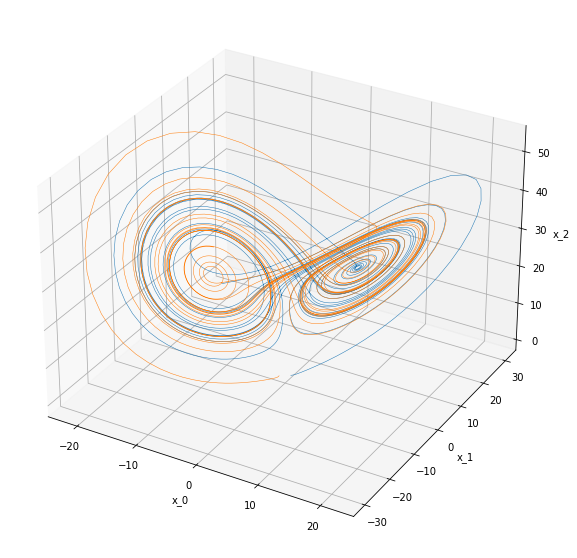

In [13]:
def plot_3d(trajectory, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection="3d")
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], lw=0.5)
    ax.set_xlabel("x_0")
    ax.set_ylabel("x_1")
    ax.set_zlabel("x_2")
    
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
plot_3d(train_dataset[0], ax=ax)
plot_3d(train_dataset[1], ax=ax)
plt.show()

### On second thought, how about we try a sine function first?

In [14]:
def sample_sin(seed):
    start = jr.uniform(seed) * 2 *  np.pi
    x = np.linspace(start, start + 25, 1000)
    return np.sin(x)

num_trials = 5

seeds = jr.split(jr.PRNGKey(0), num_trials)
train_dataset = jax.vmap(sample_sin)(seeds)
train_dataset = train_dataset[:, :, None]

seeds = jr.split(jr.PRNGKey(42), num_trials)
test_dataset = jax.vmap(sample_sin)(seeds)
test_dataset = test_dataset[:, :, None]

In [15]:
# create a new test rnn
num_input_dims = 1
num_latent_dims = 1
test_rnn = GRU(num_input_dims, num_latent_dims, seed=jr.PRNGKey(42))

In [16]:
train_inputs = train_dataset[:, :-1]
train_outputs = train_dataset[:, 1:]

test_inputs = test_dataset[:, :-1]
test_outputs = test_dataset[:, 1:]

In [17]:
from jax import value_and_grad, jit
from jax.experimental import optimizers
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

@jit
def mse_loss(model, inputs, outputs, seed):
    num_steps = inputs.shape[-2]
    _, pred_outputs = model.sample(key=seed, num_steps=num_steps, covariates=inputs)
    return np.mean(np.square(pred_outputs - outputs))


@jit
def step(step, opt_state, inputs, outputs, seed):
    value, grads = value_and_grad(mse_loss)(opt.params_fn(opt_state), inputs, outputs, seed)
    opt_state = opt.update_fn(step, grads, opt_state)
    return value, opt_state


seed = jr.PRNGKey(1)
num_epochs = 1000
train_losses = []
val_losses = []

opt = optimizers.adam(step_size=1e-5)
opt_state = opt.init_fn(test_rnn)
for epoch in tqdm(range(1, num_epochs + 1)):
    for i, (train_input, train_output) in enumerate(zip(train_inputs, train_outputs)):
        seed, this_seed = jr.split(seed, 2)
        loss, opt_state = step(epoch * i, opt_state, train_input, train_output, this_seed)
        train_losses.append(loss)
        
    # validation
    val_loss = 0.
    for (test_input, test_output) in zip(test_inputs, test_outputs):
        val_loss += mse_loss(opt.params_fn(opt_state), test_input, test_output, this_seed)
    val_loss /= test_dataset.shape[0]
    val_losses.append((epoch * i, val_loss))
val_losses = np.array(val_losses)


100%|██████████| 1000/1000 [00:02<00:00, 336.44it/s]


Text(0, 0.5, 'mse loss')

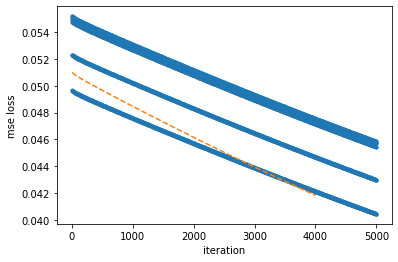

In [18]:
plt.plot(train_losses, '.', label="train")
plt.plot(val_losses[:, 0], val_losses[:, 1], '--', label="val")
plt.xlabel("iteration")
plt.ylabel("mse loss")

In [19]:
fit_rnn = opt.params_fn(opt_state)

num_timesteps = train_inputs.shape[-2]
fit_test_states, fit_test_data = fit_rnn.sample(key=jr.PRNGKey(0), covariates=train_inputs, num_steps=num_timesteps, num_samples=num_trials)
fit_states, fit_data = fit_rnn.sample(key=jr.PRNGKey(0), covariates=test_inputs, num_steps=num_timesteps, num_samples=num_trials)

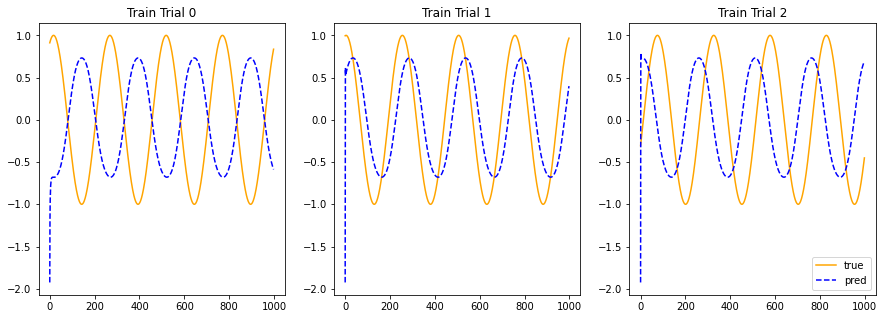

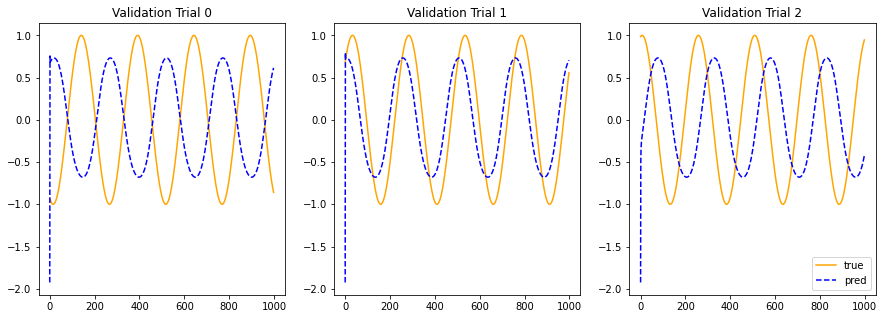

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx in range(3):
    axs[idx].set_title(f"Train Trial {idx}")
    axs[idx].plot(train_outputs[idx], color="orange", label="true")
    axs[idx].plot(fit_data[idx], '--', color="blue", label="pred")
plt.legend()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx in range(3):
    axs[idx].set_title(f"Validation Trial {idx}")
    axs[idx].plot(test_outputs[idx], color="orange", label="true")
    axs[idx].plot(fit_test_data[idx], '--', color="blue", label="pred")
plt.legend()
plt.show()